# 1. Eager execution

텐서플로의 즉시 실행은 그래프를 생성하지 않고 함수를 바로 실행하는 명령형 프로그래밍 환경입니다.
나중에 실행하기 위해 계산가능한 그래프를 생성하는 대신에 계산값을 즉시 알려주는 연산입니다.
이러한 기능은 텐서플로를 시작하고 모델을 디버깅하는 것을 더욱 쉽게 만들고 불필요한 상용구 코드(boilerplate code) 작성을 줄여줍니다.
가이드를 따라하려면, 대화형 `파이썬` 해석기(interpreter)를 이용해 아래에 있는 코드 샘플을 실행하세요.

즉시 실행은 연구와 실험을 위한 유연한 기계학습 플랫폼으로 다음과 같은 기능을 제공합니다:

* *직관적인 인터페이스*-코드를 자연스럽게 구조화하고 파이썬의 데이터 구조를 활용. 작은 모델과 작은 데이터를 빠르게 반복
* *손쉬운 디버깅*-실행중인 모델을 검토하거나 변경 사항을 테스트해보기 위해서 연산을 직접 호출. 에러 확인을 위해서 표준 파이썬 디버깅 툴을 사용
* *자연스런 흐름 제어*-그래프 제어 흐름 대신에 파이썬 제어 흐름을 사용함으로써 동적인 모델 구조의 단순화

즉시 실행은 대부분의 텐서플로 연산과 GPU 가속을 지원합니다.

## 기본 사용법

In [4]:
import tensorflow as tf

In [5]:
import logging    # 경고 출력 금지
logging.getLogger('tensorflow').disabled = True

텐서플로 2.0에서 즉시 실행은 기본으로 활성화되어 있습니다.

In [6]:
tf.executing_eagerly()

True

이제부터는 텐서플로 연산을 바로 실행할 수 있고 결과를 즉시 확인할 수 있습니다:

In [7]:
x = [[1,2]]
y = [[3],[4]]
m = tf.matmul(x, y)
print("hello, {}".format(m))

hello, [[11]]


즉시 실행 활성화는 텐서플로 연산을 바로 평가하고 그 결과를 파이썬에게 알려주는 방식으로 동작을 변경합니다.
`tf.Tensor` 객체는 계산 그래프에 있는 노드를 가르키는 간접 핸들(symbolic handle) 대신에 구체적인 값을 참조합니다.
나중에 실행하기 위해서 생성된 계산 그래프가 없기 때문에, `print()`나 디버거를 통해서 결과를 검토하기 쉽습니다.
텐서값을 평가, 출력하거나 확인하는 것이 그래디언트(gradients)를 계산하는 흐름을 방해하지 않습니다.

즉시 실행은 [NumPy](http://www.numpy.org/)와 같이 잘 작동됩니다.
NumPy 연산에 `tf.Tensor`를 매개변수로 사용가능합니다.
텐서플로 [수학 연산](https://www.tensorflow.org/api_guides/python/math_ops)은 파이썬 객체와 NumPy 배열을 `tf.Tensor` 객체로 변환합니다.
`tf.Tensor.numpy` 메서드는 객체 값을 NumPy `ndarray`로 반환합니다.

In [8]:
a = tf.constant([[1, 2],
                 [3, 4]])
print(a)

tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32)


In [9]:
# 브로드캐스팅(Broadcasting) 지원
b = tf.add(a, 1)
print(b)

tf.Tensor(
[[2 3]
 [4 5]], shape=(2, 2), dtype=int32)


In [10]:
# 연산자 오버로딩 지원
print(a * b)

tf.Tensor(
[[ 2  6]
 [12 20]], shape=(2, 2), dtype=int32)


In [11]:
# NumPy값 사용
import numpy as np

c = np.multiply(a, b)
print(c)

[[ 2  6]
 [12 20]]


In [12]:
# 텐서로부터 numpy 값 얻기:
print(a.numpy())

[[1 2]
 [3 4]]


## 동적인 제어 흐름

즉시 실행의 가장 큰 이점은 모델을 실행하는 동안에도 호스트 언어의 모든 기능을 활용할 수 있다는 것입니다.
그래서 다음과 같이 [fizzbuzz](https://en.wikipedia.org/wiki/Fizz_buzz)를 손쉽게 작성할 수 있습니다:

In [13]:
def fizzbuzz(max_num):
  counter = tf.constant(0)
  max_num = tf.convert_to_tensor(max_num)
  for num in range(1, max_num.numpy()+1):
    num = tf.constant(num)
    if int(num % 3) == 0 and int(num % 5) == 0:
      print('FizzBuzz')
    elif int(num % 3) == 0:
      print('Fizz')
    elif int(num % 5) == 0:
      print('Buzz')
    else:
      print(num.numpy())
    counter += 1

In [14]:
fizzbuzz(15)

1
2
Fizz
4
Buzz
Fizz
7
8
Fizz
Buzz
11
Fizz
13
14
FizzBuzz


여기에 텐서값에 따른 조건절이 있고 실행중에 그 결과를 출력합니다.

## 즉시 훈련

### 그래디언트 계산하기

[자동 미분](https://en.wikipedia.org/wiki/Automatic_differentiation)은 인공 신경망 훈련을 위한
[역전파](https://en.wikipedia.org/wiki/Backpropagation)와 같은 기계학습 알고리즘을 구현하는데 유용합니다.
즉시 실행을 사용하는 동안에는, 나중에 그래디언트를 계산하는 연산을 추적하기 위해 `tf.GradientTape`을 사용하세요.

즉시 실행 중에 그래디언트를 계산하고 모델 훈련에 이용하기 위해서 `tf.GradientTape`을 사용할 수 있습니다.
특히 복잡하고 반복적인 훈련인 경우에 더 유용합니다.

매번 실행될 때 서로 다른 연산이 수행될 수 있기 때문에 모든 정방향(forward-pass) 연산은 "tape"에 기록됩니다.
그다음 tape를 거꾸로 돌려 그래디언트를 계산한 후 tape를 폐기합니다.
특정한 `tf.GradientTape`는 오직 하나의 그래디언트만을 계산할 수 있고 부가적인 호출은 실행중 에러(runtime error)를 발생시킵니다.

In [15]:
w = tf.Variable([[1.0]])
with tf.GradientTape() as tape:
  loss = w * w

grad = tape.gradient(loss, w)
print(grad)  

tf.Tensor([[2.]], shape=(1, 1), dtype=float32)


### 모델 훈련

다음 예는 표준 MNIST 손글씨 분류를 위한 다층 모델을 생성합니다.
즉시 실행 환경에서 훈련가능한 그래프를 생성하기 위한 옵티마이저(optimizer)와 층 API를 보여줍니다.

In [16]:
# mnist 데이터 가져오기 및 포맷 맞추기
(mnist_images, mnist_labels), _ = tf.keras.datasets.mnist.load_data()

dataset = tf.data.Dataset.from_tensor_slices(
  (tf.cast(mnist_images[...,tf.newaxis]/255, tf.float32),
   tf.cast(mnist_labels,tf.int64)))
dataset = dataset.shuffle(1000).batch(32)

In [17]:
# 모델 생성
mnist_model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16,[3,3], activation='relu',
                         input_shape=(None, None, 1)),
  tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10)
])

즉시 실행에서는 훈련을 하지 않아도 모델을 사용하고 결과를 점검할 수 있습니다:

In [18]:
for images,labels in dataset.take(1):
  print("로짓: ", mnist_model(images[0:1]).numpy())

로짓:  [[-0.00309802 -0.00779656  0.00642204 -0.02162785  0.02082167  0.03030453
  -0.01756391  0.00902968  0.01723027 -0.01375335]]


케라스 모델은 자체적인 훈련 메서드(fit)을 포함하고 있지만 때로는 좀 더 수정할 필요가 있습니다.
다음은 즉시 실행을 활용한 반복적인 훈련의 예입니다:

In [19]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss_history = []

Note: 조건을 만족했는지 확인하기 위해서 `tf.debugging`에 있는 단언문(assert) 함수를 사용하세요. 이것은 즉시 실행과 그래프 실행 모두에서 동작합니다.

In [27]:
def train_step(images, labels):
  with tf.GradientTape() as tape:
    logits = mnist_model(images, training=True)
    
    # 결과의 형태를 확인하기 위해서 단언문 추가
    tf.debugging.assert_equal(logits.shape, (32, 10))
    
    loss_value = loss_object(labels, logits)

  loss_history.append(loss_value.numpy().mean())
  grads = tape.gradient(loss_value, mnist_model.trainable_variables)
  optimizer.apply_gradients(zip(grads, mnist_model.trainable_variables))

In [28]:
def train():
  for epoch in range(3):
    for (batch, (images, labels)) in enumerate(dataset):
      train_step(images, labels)
    print ('에포크 {} 종료'.format(epoch))

In [29]:
train()

에포크 0 종료
에포크 1 종료
에포크 2 종료


Text(0, 0.5, 'Loss [entropy]')

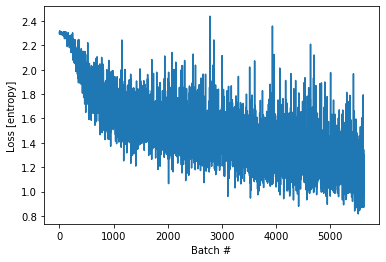

In [31]:
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel('Batch #')
plt.ylabel('Loss [entropy]')

### 변수와 옵티마이저

`tf.Variable` 객체는 자동 미분을 쉽게 하기 위해서 학습동안 변경된 `tf.Tensor` 값을 저장합니다.
모델 파라미터는 클래스 인스턴스 변수로 캡슐화될 수 있습니다.

효과적으로 모델 파라미터를 캡슐화하려면 `tf.Variable`을 `tf.GradientTape`과 함께 사용합니다.
예를 들어, 위의 자동 미분은 다음과 같이 재작성 가능합니다:

In [32]:
class Model(tf.keras.Model):
  def __init__(self):
    super(Model, self).__init__()
    self.W = tf.Variable(5., name='weight')
    self.B = tf.Variable(10., name='bias')
  def call(self, inputs):
    return inputs * self.W + self.B

# 약 3 * x + 2개의 점으로 구성된 실험 데이터
NUM_EXAMPLES = 2000
training_inputs = tf.random.normal([NUM_EXAMPLES])
noise = tf.random.normal([NUM_EXAMPLES])
training_outputs = training_inputs * 3 + 2 + noise

# 최적화할 손실함수
def loss(model, inputs, targets):
  error = model(inputs) - targets
  return tf.reduce_mean(tf.square(error))

def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets)
  return tape.gradient(loss_value, [model.W, model.B])

# 정의:
# 1. 모델
# 2. 모델 파라미터에 대한 손실 함수의 미분
# 3. 미분에 기초한 변수 업데이트 전략
model = Model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

print("초기 손실: {:.3f}".format(loss(model, training_inputs, training_outputs)))

# 반복 훈련
for i in range(300):
  grads = grad(model, training_inputs, training_outputs)
  optimizer.apply_gradients(zip(grads, [model.W, model.B]))
  if i % 20 == 0:
    print("스텝 {:03d}에서 손실: {:.3f}".format(i, loss(model, training_inputs, training_outputs)))

print("최종 손실: {:.3f}".format(loss(model, training_inputs, training_outputs)))
print("W = {}, B = {}".format(model.W.numpy(), model.B.numpy()))

초기 손실: 68.411
스텝 000에서 손실: 65.757
스텝 020에서 손실: 30.008
스텝 040에서 손실: 13.996
스텝 060에서 손실: 6.824
스텝 080에서 손실: 3.611
스텝 100에서 손실: 2.171
스텝 120에서 손실: 1.526
스텝 140에서 손실: 1.237
스텝 160에서 손실: 1.107
스텝 180에서 손실: 1.049
스텝 200에서 손실: 1.023
스텝 220에서 손실: 1.011
스텝 240에서 손실: 1.006
스텝 260에서 손실: 1.004
스텝 280에서 손실: 1.003
최종 손실: 1.002
W = 3.0058913230895996, B = 2.029695987701416


## 즉시 실행에서 상태를 위한 객체 사용

텐서플로 1.x 그래프 실행에서, 프로그램 상태(예: 변수)는 전역 컬렉션에 저장되고 그 수명은 `tf.Session` 객체에 의해서 관리됩니다.
반면에 즉시 실행에서 상태 객체 수명은 그와 관련된 파이썬 객체 수명에 의해서 결정됩니다.

### 변수는 객체입니다

즉시 실행에서 변수는 그 객체의 마지막 참조가 제거될 때까지 유지되고 그 이후 삭제됩니다.

In [33]:
v = tf.Variable(tf.random.normal([1000, 1000]))
v = None  # v는 더이상 메모리를 사용하지 않음

### 객체 기반의 저장

`tf.train.Checkpoint`는 `tf.Variable`을 체크포인트 파일로 저장하거나 체크포인트 파일에서 복구할 수 있습니다:

In [34]:
x = tf.Variable(10.)
checkpoint = tf.train.Checkpoint(x=x)

In [35]:
x.assign(2.)   # 변수에 새로운 값을 할당하고 저장
checkpoint_path = './ckpt/'
checkpoint.save('./ckpt/')

'./ckpt/-1'

In [36]:
x.assign(11.)  # 저장한 후에 변수 변경

# 체크포인트로부터 값을 복구
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

print(x)  

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=2.0>


모델을 저장하거나 읽어들이기 위해서, `tf.train.Checkpoint`는 숨겨진 변수를 요구하지 않고 객체 내부 상태를 저장합니다. 
`옵티마이저`와 `모델`, 전역 단계 상태를 기록하려면 `tf.train.Checkpoint`에 전달하면 됩니다:

In [37]:
import os

model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16,[3,3], activation='relu'),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
checkpoint_dir = 'path/to/model_dir'
if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
root = tf.train.Checkpoint(optimizer=optimizer,
                           model=model)

root.save(checkpoint_prefix)
root.restore(tf.train.latest_checkpoint(checkpoint_dir))

Note: 대부분의 반복 훈련 과정에서 변수는 `tf.train.Checkpoint.restore`가 호출된 이후에 생성됩니다.
이러한 변수는 생성되자마자 복원될 것이므로 단언문을 통해 체크포인트가 완벽히 적재되었다는 것을 보장받을 수 있습니다.

### 객체 지향형 지표

`tf.keras.metrics`는 객체로 저장됩니다.
새로운 데이터를 이 객체에 전달하여 지표를 수정하고 `tf.keras.metrics.result` 메서드를 사용해 그 결과를 얻습니다.
예를 들어:

In [38]:
m = tf.keras.metrics.Mean("loss")
m(0)
m(5)
print(m.result())

m([8, 9])
print(m.result())

tf.Tensor(2.5, shape=(), dtype=float32)
tf.Tensor(5.5, shape=(), dtype=float32)


### 서머리(summary)와 텐서보드

[텐서보드](https://tensorflow.org/tensorboard)는 훈련과정에서 모델을 파악하거나 디버깅하고 최적화하기 위해 사용하는 시각화 도구입니다.
텐서보드는 프로그램이 실행되는 동안 작성된 서머리 이벤트를 사용합니다.

즉시 실행에서 변수의 서머리 정보를 기록하기 위해서 `tf.summary`를 사용합니다.
예를 들어, 다음은 매 100번째 훈련마다 `loss`의 서머리 정보를 기록합니다:

In [39]:
logdir = "./tb/"
writer = tf.summary.create_file_writer(logdir)

with writer.as_default():  # 또는 반복 전에 writer.set_as_default()를 호출
  for i in range(1000):
    step = i + 1
    # 실제 훈련 함수로 손실을 계산
    loss = 1 - 0.001 * step
    if step % 100 == 0:
      tf.summary.scalar('손실', loss, step=step)

In [40]:
!dir tb

 F 드라이브의 볼륨: 새 볼륨
 볼륨 일련 번호: 2E0F-004F

 F:\텐서플로우_수업자료\실습소스\tb 디렉터리

2021-03-20  오후 04:45    <DIR>          .
2021-03-20  오후 04:45    <DIR>          ..
2021-03-20  오후 04:25               689 events.out.tfevents.1616225127.DESKTOP-GA61A0D.18300.12448.v2
2021-03-20  오후 04:45               689 events.out.tfevents.1616226330.DESKTOP-GA61A0D.20776.636574.v2
               2개 파일               1,378 바이트
               2개 디렉터리  620,937,502,720 바이트 남음


## 성능

즉시 실행에서 계산은 자동으로 GPU로 분배됩니다.
만약 계산 분배를 사용자가 제어하고 싶다면 그 부분을 `tf.device('/gpu:0')` 블록 (또는 CPU도 동일)으로 감싸서 실행하세요:

In [41]:
import time

def measure(x, steps):
  # 텐서플로는 처음 사용할 때 GPU를 초기화, 시간계산에서 제외
  tf.matmul(x, x)
  start = time.time()
  for i in range(steps):
    x = tf.matmul(x, x)
  # tf.matmul는 행렬 곱셈을 완료하기 전에 결과를 반환할 수 있습니다
  # (예, CUDA 스트림 대기열에 연산을 추가한 후에 결과를 반환할 수 있다).
  # 아래 x.numpy() 호출은 대기열에 추가된 모든 연산이 완료될 것임을 보장합니다
  # (그리고 그 결과가 호스트 메모리에 복사될 것이고,
  # 그래서 matmul 연산시간보다는 조금 많은 연산시간이
  # 포함됩니다).
  _ = x.numpy()
  end = time.time()
  return end - start

shape = (1000, 1000)
steps = 200
print("{} 크기 행렬을 자기 자신과 {}번 곱했을 때 걸리는 시간:".format(shape, steps))

# CPU에서 실행:
with tf.device("/cpu:0"):
  print("CPU: {} 초".format(measure(tf.random.normal(shape), steps)))

# GPU에서 실행, 가능하다면:
if tf.config.experimental.list_physical_devices("GPU"):
  with tf.device("/gpu:0"):
    print("GPU: {} 초".format(measure(tf.random.normal(shape), steps)))
else:
  print("GPU: 없음")

(1000, 1000) 크기 행렬을 자기 자신과 200번 곱했을 때 걸리는 시간:
CPU: 0.5993199348449707 초
GPU: 0.02000570297241211 초


`tf.Tensor` 객체는 실제로 그 연산을 수행할 다른 디바이스로 복사될 수 있습니다:

In [43]:
if tf.config.experimental.list_physical_devices("GPU"):
  x = tf.random.normal([10, 10])

  x_gpu0 = x.gpu()
  x_cpu = x.cpu()

  _ = tf.matmul(x_cpu, x_cpu)    # CPU에서 실행
  _ = tf.matmul(x_gpu0, x_gpu0)  # GPU:0에서 실행